# Sentiment Analysis using LanceDB

Sentiment analysis, is a technique used in NLP to determine the emotional undertone of a text. This is a common method used by organizations to identify and group opinions about their product, service, and ideas.
<br>
In this notebook, we will apply this technique to the Hotel Industry and understand Customer Perception and Potential areas that need improvement. To do this, we will:

1.	Generate Sentiment labels and scores based on customer reviews.
2.	Store them in a LanceDB table with metadata and their embeddings of customer reviews.
3.	Query LanceDB table on selected areas and understand customer opinions.

Let's get started.


## Install Dependencies

In [ ]:
!pip install sentence_transformers datasets seaborn matplotlib lancedb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 980.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 12.9 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=b4cd24cfbbc25c5f79ed9ef87c6364081b39e484bb290d5c2dbe04787c885b02
  Stored in directory: /root/.cache/pip/whee

## Load and Prepare Dataset

We use a dataset containing ~90k hotel reviews provided by customers. This dataset can be loaded from the HuggingFace dataset hub as follows:

In [ ]:
from datasets import load_dataset

# load the dataset and convert to pandas dataframe
df = load_dataset(
    "ashraq/hotel-reviews",
    split="train"
).to_pandas()

In [ ]:
# keep only the first 1000 characters from the reviews
df["review"] = df["review"].str[:1000]
# glimpse the dataset
df.head()

,review_date,hotel_name,review
0,8/3/2017,Park Plaza County Hall London,Extra bed was the worst breakfast queue was r...
1,8/3/2017,Park Plaza County Hall London,Just the location and view
2,8/3/2017,Park Plaza County Hall London,Around the corner from the London eye and use...
3,8/2/2017,Park Plaza County Hall London,I wish you had wheat free snacks
4,8/2/2017,Park Plaza County Hall London,You re always my hotel of choice You re staff...


## Initialize Sentiment Analysis Model

We will use a RoBERTa model fine-tuned for sentiment analysis to analyze the hotel reviews. The model can be loaded from the HuggingFace model hub as follows:

In [ ]:
import torch

# set device to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# @title Select Sentiment Analysis Model and run this cell

model_id = "cardiffnlp/twitter-roberta-base-sentiment" # @param {type:"string"}
select_model = 'cardiffnlp/twitter-roberta-base-sentiment' # @param ["cardiffnlp/twitter-roberta-base-sentiment", "lxyuan/distilbert-base-multilingual-cased-sentiments-student"]
model_id = select_model
print("Selected Model: ", model_id)

Selected Model:  cardiffnlp/twitter-roberta-base-sentiment


In [ ]:
#checking selected sentiment analysis model
model_id

'cardiffnlp/twitter-roberta-base-sentiment'

In [ ]:
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification
    )

# load the model from huggingface
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=3
)

# load the tokenizer from huggingface
tokenizer = AutoTokenizer.from_pretrained(model_id)

# load the tokenizer and model into a sentiment analysis pipeline
nlp = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device
    )

The sentiment analysis model returns `LABEL_0` for negative, `LABEL_1` for neutral and `LABEL_2` for positive labels. We can add them to a dictionary to easily access them when showing the results.

In [ ]:
if model_id == "cardiffnlp/twitter-roberta-base-sentiment":
    labels = {
        "LABEL_0": "negative",
        "LABEL_1": "neutral",
        "LABEL_2": "positive"
    }
elif model_id == "lxyuan/distilbert-base-multilingual-cased-sentiments-student":
    labels = {
        "negative": "negative",
        "neutral": "neutral",
        "positive": "positive"
    }

In [ ]:
# view review number 241
test_review = df["review"][241]
test_review

' Room was small for a superior room and poorly lit especially as it was an inside room and overlooked the inside wall of the hotel No view therefore needed better lighting within Restaurant tables were not well laid and had to go searching for cutlery at breakfast '

In [ ]:
# get the sentiment label and score for review number 241
nlp(test_review)

[{'label': 'LABEL_0', 'score': 0.7736574411392212}]

Our pipeline is working as expected and accurately predicts the correct label for the review.

## Initialize Retriever

A retriever model is used to embed passages and queries, and it creates embeddings such that queries and passages with similar meanings are close in the vector space. We will use a sentence-transformer model as our retriever. The model can be loaded as follows:

In [ ]:
from sentence_transformers import SentenceTransformer

# load the model from huggingface
retriever = SentenceTransformer(
    'sentence-transformers/all-MiniLM-L6-v2',
    device=device
)
retriever

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

## Initialize LanceDB

In [ ]:
import lancedb
db = lancedb.connect("./.lancedb")

## Generate Embeddings and Insert into table

We generate embeddings for all the reviews in the dataset. Alongside the embeddings, we also include the sentiment label and score in the LanceDB table as metadata. Later we will use this data to understand customer opinions.

Let's first write a helper function to generate sentiment labels and scores for a batch of reviews.

In [ ]:
def get_sentiment(reviews):
    # pass the reviews through sentiment analysis pipeline
    sentiments = nlp(reviews)
    # extract only the label and score from the result
    l = [labels[x["label"]] for x in sentiments]
    s = [x["score"] for x in sentiments]
    return l, s

In [ ]:
# get sentiment labels for few reviews
get_sentiment(df["review"][:3].tolist())

(['negative', 'neutral', 'positive'],
 [0.9065250754356384, 0.7716172933578491, 0.8975034952163696])

We need to convert the review dates to timestamps to filter query results for a given period. This is helpful if you want to understand customer sentiment over a specific period. Let's write another helper function to convert dates to timestamps.

In [ ]:
import dateutil.parser

# convert date to timestamp
def get_timestamp(dates):
    timestamps = [dateutil.parser.parse(d).timestamp() for d in dates]
    return timestamps

In [ ]:
get_timestamp([df["review_date"][0]])[0]

1501718400.0

Now we create the embeddings. We do this in batches of `64` to avoid overwhelming machine resources.

In [ ]:
from tqdm.auto import tqdm

# we will use batches of 64
batch_size = 64
data = []
for i in tqdm(range(0, len(df), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(df))
    # extract batch
    batch = df.iloc[i:i_end]
    # generate embeddings for batch
    emb = retriever.encode(batch["review"].tolist()).tolist()
    # convert review_date to timestamp to enable period filters
    timestamp = get_timestamp(batch["review_date"].tolist())
    batch["timestamp"] = timestamp
    # get sentiment label and score for reviews in the batch
    label, score = get_sentiment(batch["review"].tolist())
    batch["label"] = label
    batch["score"] = score
    # get metadata
    meta = batch.to_dict(orient="records")
    # create unique IDs
    ids = [f"{idx}" for idx in range(i, i_end)]
    # add all to upsert list
    to_insert = list(zip(ids, emb, meta))
    for id, emb, meta in to_insert:
        temp = {}
        temp['ids'] = ids
        temp['vector'] = emb
        for k,v in meta.items():
            temp[k] = v
        data.append(temp)

  0%|          | 0/1465 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
<ipython-input-128-d512a884ffe7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch["timestamp"] = timestamp
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
<ipython-input-128-d512a884ffe7>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch["label"] = label
<ipython-input-128-d512a8

In [ ]:
# create and insert these records to lancedb table
tbl = db.create_table("tbl", data, mode= "overwrite")

We have successfully inserted all customer reviews and relevant metadata. We can move on to analyzing sentiments.

# Analyzing Sentiments

Now that we have all the customer reviews inserted, we will search for a few areas that customers usually consider when staying at a hotel and analyze the general opinion of the customers.
<br>

LanceDB vector database makes it very flexible and faster to do this as we can easily search for any topic and get customer reviews relevant to the search query along with sentiment labels as metadata.

We will start with a general question about the room sizes of hotels in London and return the top 100 reviews to analyze the overall customer sentiment.

In [ ]:
def count_sentiment(result):
    # store count of sentiment labels
    sentiments = {
        "negative": 0,
        "neutral": 0,
        "positive": 0,
    }
    # iterate through search results
    for r in result:
        # extract the sentiment label and increase its count
        sentiments[r["label"]] += 1
    return sentiments

**Analyzing Room Size Reviews in London**

In [ ]:
query = "What is customers opinion about room sizes in London?"
# generate dense vector embeddings for the query
xq = retriever.encode(query).tolist()

# query lancedb
metadata = ["hotel_name", "label", "review", "review_date", "timestamp"]
result = tbl.search(xq).select(metadata).limit(100).to_list()

Let's take a look at a few reviews from the search results.

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

for r in result[:2]:
    data = {}
    for m in metadata:
        data[m] = r[m]
    pp.pprint(data)

{   'hotel_name': 'Grand Royale London Hyde Park',
    'label': 'positive',
    'review': ' Room could be bigger but I can t complain given its ideal '
              'location in London ',
    'review_date': '9/11/2015',
    'timestamp': 1441929600.0}
{   'hotel_name': 'Grand Royale London Hyde Park',
    'label': 'neutral',
    'review': ' Room quite small but what do you expect for London ',
    'review_date': '2/10/2016',
    'timestamp': 1455062400.0}


Now let's see the overall perception of the customers on London hotel room sizes.

First, we need to extract the sentiment labels from the query results and count them for that we'll utilize helper function `count_sentiments`

In [ ]:
sentiment = count_sentiment(result)
sentiment

{'negative': 9, 'neutral': 40, 'positive': 51}

## Plot Results

Let's plot the result for a better view.

<Axes: >

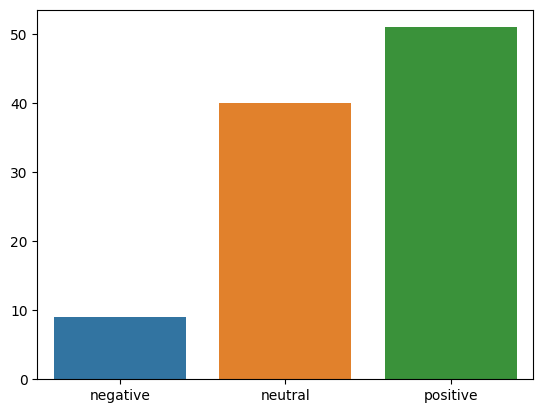

In [ ]:
import seaborn as sns

# plot a barchart using seaborn
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))

**The customers are generally satisfied with the room sizes, although many are still neutral and positive.**

We can be even more specific when searching for reviews with the help of LanceDB's filtering. For instance, we can specify a period in our query to ensure that search results only contain customer reviews for that period. This is helpful if you want to understand the customer's opinion during a specific period.

Let's do this for the same query as before. We will filter reviews from 25th December 2015 to 31st December 2017. Previously we added the `review_date` field as a timestamp to the metadata during indexing. We can convert the start and end date of the period to timestamp using the `get_timestamp` function and use a `greater than or equal to and a less than or equal to filter` to get reviews from only the selected period.

**Analyzing Room Size Reviews in a specific period**

In [ ]:
# generate timestamps for start and end time of the period
start_time = get_timestamp(["2015-01-01"])[0]
end_time = get_timestamp(["2017-12-31"])[0]

<Axes: >

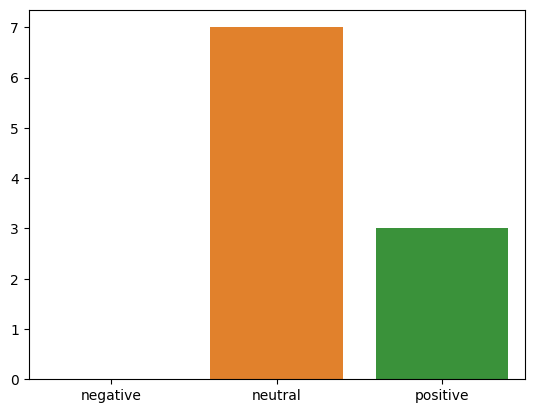

In [ ]:
query = "are the customers satisified with the room sizes of hotels in London?"
# generate query embeddings
xq = retriever.encode(query).tolist()

# query lancedb with query embeddings and appling prefiltering for given time period
where_filter = f"{start_time} <= timestamp <= {end_time}"
result = tbl.search(xq).where(where_filter, prefilter=True).limit(10).to_list()

# get an overall count of customer sentiment
sentiment = count_sentiment(result)
# plot a barchart using seaborn
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))

**We have a slightly different result now. Almost the same number of customers had either a neutral or positive view of the room size during the selected period.**

**Analyzing Cleaniness in Hotels of London**

<Axes: >

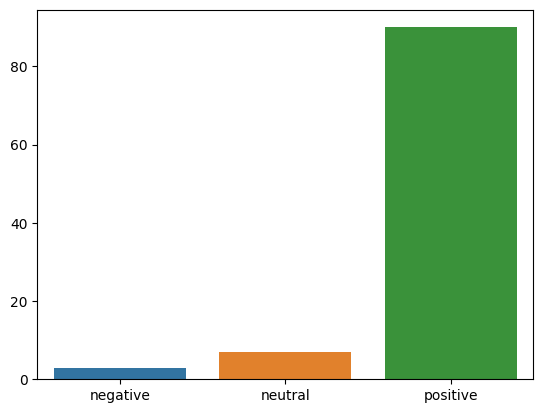

In [ ]:
query = "What is customers opinion about cleaniness in London Hotels?"
# generate dense vector embeddings for the query
xq = retriever.encode(query).tolist()

# query lancedb
metadata = ["hotel_name", "label", "review", "review_date", "timestamp"]
result = tbl.search(xq).select(metadata).limit(100).to_list()

#sentiments count
sentiment = count_sentiment(result)
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))

**We can see picture about cleaniness in London Hotels is very positive, there are few neutral and negative reviews but overall picture is positive**

#### Analyzing Multiple hotels at Multiple Grounds

In [ ]:
#all the unique hotels in dataset
df.hotel_name.unique()

array(['Park Plaza County Hall London', 'Grand Royale London Hyde Park',
       'Intercontinental London The O2',
       'M by Montcalm Shoreditch London Tech City',
       'Britannia International Hotel Canary Wharf',
       'Park Plaza London Riverbank', 'Hilton London Metropole',
       'DoubleTree by Hilton London Docklands Riverside',
       'Park Grand Paddington Court', 'Blakemore Hyde Park',
       'Park Grand London Kensington', 'Strand Palace Hotel',
       'Millennium Gloucester Hotel London',
       'St James Court A Taj Hotel London',
       'DoubleTree by Hilton Hotel London Tower of London',
       'Hilton London Wembley', 'Copthorne Tara Hotel London Kensington',
       'Hotel Da Vinci', 'Park Plaza Westminster Bridge London',
       'Holiday Inn London Kensington'], dtype=object)

In [ ]:
#selected hotels
hotels =[
    "Strand Palace Hotel",
    "St James Court A Taj Hotel London",
    "Grand Royale London Hyde Park",
    "Hotel Da Vinci",
    "Intercontinental London The O2",
]

We will look into five main areas:
  1. Room Size
  2. Cleanliness
  3. Room Service
  4. Food Service
  5. Ventilation

We have a query for each of these areas below.

In [ ]:
queries = {
    "room size": "are customers happy with the given room sizes?",
    "cleanliness": "are customers satisfied with the cleanliness of the rooms?",
    "room service": "did the customers like how they were treated by the staff while room service?",
    "food service": "did the customers enjoy the food and servicing?",
    "ventilation": "customer opinion on the air passage and AC"
}

We need to iterate through all the hotels and run these queries for each hotel. This would give us customer reviews relevant to the selected hotel areas. After that, we count the sentiment labels and plot results for each hotel.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

hotel_sentiments = []

# iterate through the hotels
for hotel in hotels:
    final_result = []

    # iterate through the keys and values in the queries dict
    for area, query in queries.items():
        # generate query embeddings
        xq = retriever.encode(query).tolist()

        # query lancedb with query embeddings and appling prefiltering for hotel names
        where_filter = f"hotel_name= '{hotel}'"
        result = tbl.search(xq).where(where_filter, prefilter=True).limit(100).to_list()

        # get an overall count of customer sentiment
        sentiment = count_sentiment(result)
        # sort the sentiment to show area and each value side by side
        for k, v in sentiment.items():
            analysis_data = {
                "area": area,
                "label": k,
                "value": v
            }
            # add the data to final_result list
            final_result.append(analysis_data)

    #dataframe of final results
    df = pd.DataFrame(final_result)
    # mapping dataframe records with hotel
    hotel_sentiments.append({"hotel": hotel, "df": df})


Let's see what our final data look like.

In [ ]:
hotel_sentiments[0]["df"]

,area,label,value
0,room size,negative,25
1,room size,neutral,49
2,room size,positive,26
3,cleanliness,negative,6
4,cleanliness,neutral,18
5,cleanliness,positive,76
6,room service,negative,19
7,room service,neutral,3
8,room service,positive,78
9,food service,negative,11


We may now plot the final data to make inferences.

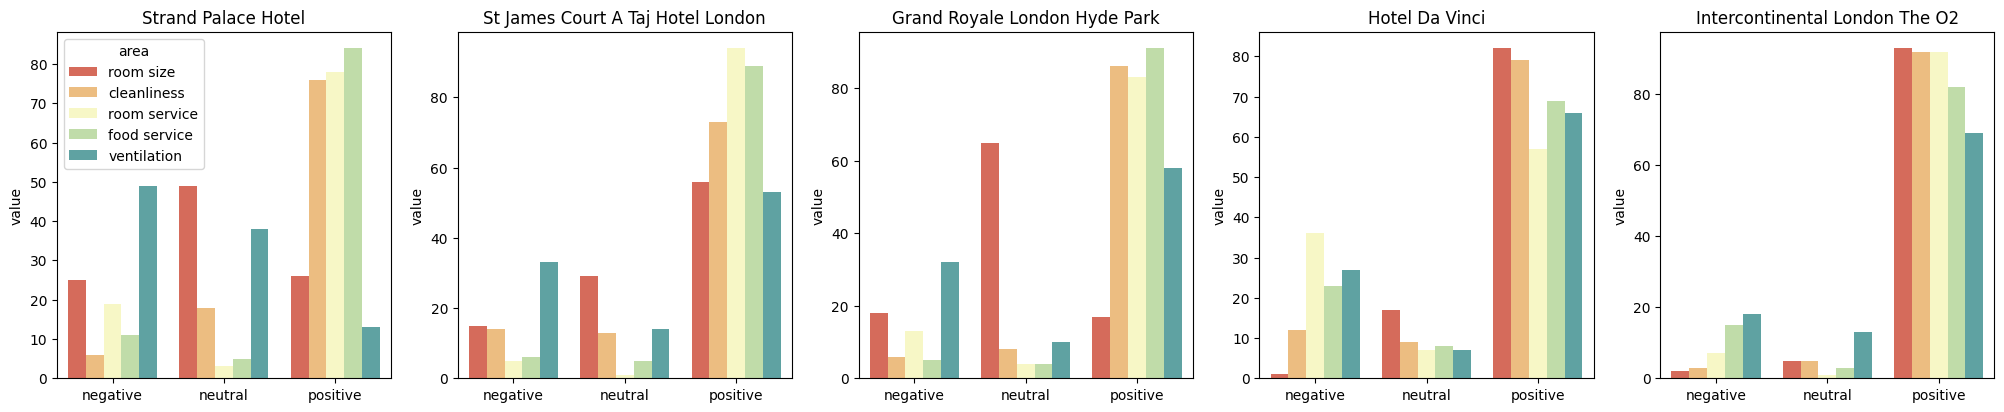

In [ ]:
# create the figure and axes to plot barchart for all hotels
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25, 4.5))
plt.subplots_adjust(hspace=0.25)

counter = 0
# iterate through each hotel in the list and plot a barchart
for d, ax in zip(hotel_sentiments, axs.ravel()):
    # plot barchart for each hotel
    sns.barplot(x="label", y="value", hue="area", data=d["df"], ax=ax, palette="Spectral")
    # display the hotel names
    ax.set_title(d["hotel"])
    # remove x labels
    ax.set_xlabel("")
    # remove legend from all charts except for the first one
    counter += 1
    if counter != 1: ax.get_legend().remove()
# display the full figure
plt.show()

The following observations can be made for the hotels based on the sentiment analysis:
1.  **Strand Palace Hotel:** majority customers were pleased with the cleanliness, room service, and food service of the rooms, while considerable number of them were not very satisfied with the room sizes and the ventilation in rooms.
2.  **St James Court A Taj Hotel London:** the majority of the customers were really happy with the selected five areas
3.  **Grand Royale London Hyde Park**: the majority of the customers were not satisfied with the room size, while a good number of them were pretty satisfied with the cleanliness, room service, food service, and ventilation of the rooms.
4. **Hotel Da Vinci**: majority of customers are happy with room sizes, cleanliness, food service and ventilation but considerable about of them are not satisfied with room service
4.  **Intercontinental London The O2**: the majority of the customers were really happy with the selected five areas, making this hotel the best among the selected hotels.


Although we have experimented with a few selected areas and hotels, you can get creative with your queries and get the sentiment around your area of interests with different sets of hotels immediately.